# Coronavirus Prediction

## Overview

This project predicts related rates with deep learning methods.

## Business Understanding

We are going to have some predictions for the decision makers to layout some strategies in dealing with covid-19.

## Data Understanding

Data Collection by API

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pickle

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')
#import geopandas as gpd
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
# display preferences
register_matplotlib_converters()

### Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20 \
https://covidtracking.com/data/api \
https://cord19.vespa.ai

In [2]:
# Coronavirus Tracker REST API 
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [3]:
data = pd.DataFrame(d['locations'])
data.head()

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,37172386.0,,2021-02-01T00:39:03.268933Z,"{'latitude': '33.93911', 'longitude': '67.7099...","{'confirmed': 55008, 'deaths': 2400, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
1,1,Albania,AL,2866376.0,,2021-02-01T00:39:03.301303Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 77251, 'deaths': 1369, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
2,2,Algeria,DZ,42228429.0,,2021-02-01T00:39:03.334406Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 107122, 'deaths': 2888, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
3,3,Andorra,AD,77006.0,,2021-02-01T00:39:03.367770Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 9885, 'deaths': 101, 'recovered'...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
4,4,Angola,AO,30809762.0,,2021-02-01T00:39:03.401177Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19782, 'deaths': 464, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...


In [4]:
# pd.DataFrame(d['locations'][249]['timelines']['confirmed']).plot()
# pd.DataFrame(d['locations'][249]['timelines']['deaths']).plot()

In [5]:
data[data['country_code']=='US'].iloc[:,:3]

,id,country,country_code
249,249,US,US


In [6]:
# ts = pd.DataFrame(d['locations'][249]['timelines']['deaths'])
# ts.index = pd.to_datetime(ts.index).date

In [7]:
# The covid tracking project data api 
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
dus = response.json()

df = pd.DataFrame(dus[::-1])
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20200113,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-13T24:00:00Z,None,0,0,0,0,0,0,0,5672debf187b183735be63f6bd85834ead0047ff
1,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-14T24:00:00Z,None,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8
2,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-15T24:00:00Z,None,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
3,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-16T24:00:00Z,None,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
4,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-17T24:00:00Z,None,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6


In [8]:
url = 'https://api.covidtracking.com/v1/states/daily.json'
response = requests.get(url)
daily = response.json()
df1 = pd.DataFrame(daily[::-1])
df1.head()

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200113,WA,NaN,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,4b278ad9e69da1c2a818f761c25f10c4bb6bf2a7,0,0,0,0,0,
1,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,
2,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,
3,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,
4,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,


## Data Preparation

### Exploratory Data Analysis

In [9]:
# df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
# df.set_index('date', inplace=True)
df['mortality'] = np.where(df.positiveIncrease==0, 0, df.deathIncrease/df.positiveIncrease)

(0, 0.15)

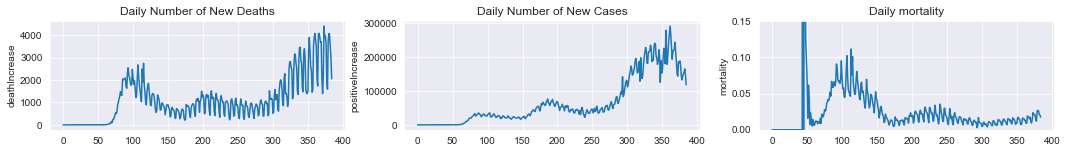

In [10]:
# plot target variables
fig, ax = plt.subplots(1, 3, figsize=(18,2))
sns.lineplot(data=df.deathIncrease, ax=ax[0])
ax[0].set_title('Daily Number of New Deaths')
sns.lineplot(data=df.positiveIncrease, ax=ax[1])
ax[1].set_title('Daily Number of New Cases')
sns.lineplot(data=df.mortality, ax=ax[2])
ax[2].set_title('Daily mortality')
ax[2].set_ylim(0, 0.15)
# plt.subplots_adjust(hspace = 0.5)

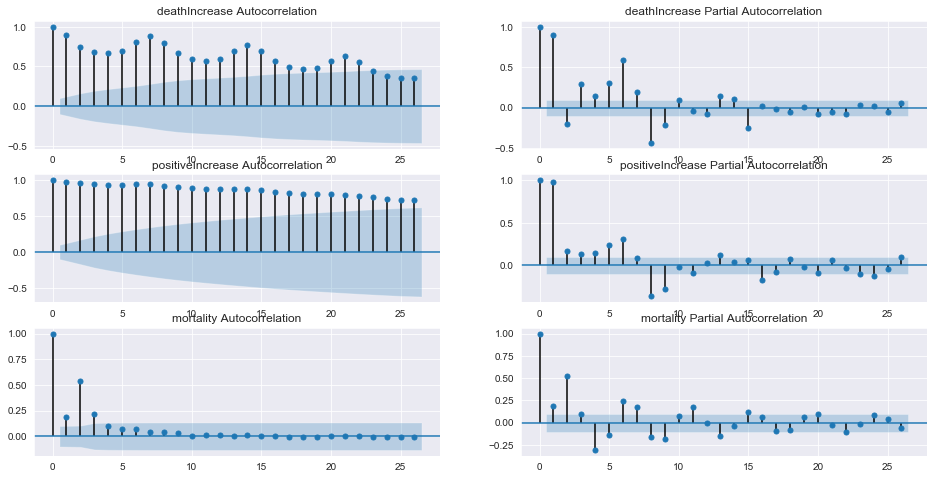

In [11]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(3, 2, figsize=(16,8))
plot_acf(df.deathIncrease, title='deathIncrease Autocorrelation', ax=ax[0][0]);
plot_pacf(df.deathIncrease, title='deathIncrease Partial Autocorrelation', ax=ax[0][1]);
plot_acf(df.positiveIncrease, title='positiveIncrease Autocorrelation', ax=ax[1][0]);
plot_pacf(df.positiveIncrease, title='positiveIncrease Partial Autocorrelation', ax=ax[1][1]);
plot_acf(df.mortality, title='mortality Autocorrelation', ax=ax[2][0]);
plot_pacf(df.mortality, title='mortality Partial Autocorrelation', ax=ax[2][1]);

### Dickey-Fuller Test

In [12]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.deathIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.deathIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [ ]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.positiveIncrease)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.positiveIncrease, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [ ]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.mortality)
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.mortality, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

In [ ]:
stationarity_check(df.deathIncrease)

In [ ]:
stationarity_check(df.positiveIncrease)

In [ ]:
stationarity_check(df.mortality)

In [ ]:
# Plot a square root transform
stationarity_check(np.sqrt(df.deathIncrease))

In [ ]:
# Plot a square root transform
stationarity_check(np.sqrt(df.positiveIncrease))

In [ ]:
stationarity_check(np.sqrt(df.mortality))

## Modeling

### ARIMA Model

In [54]:
# construct seperate dataframes per target variable
deaths = pd.DataFrame(df.deathIncrease, index=df.index)

# drop nan values from the start of each target dataframe
deaths.fillna(value=1, inplace=True)

# add one to all values of zero for log transforms
deaths['deathIncrease'] = np.where(deaths.deathIncrease == 0, 1, deaths.deathIncrease)

ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=(2,1,2),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
print(output.summary().tables[0])
print(output.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:          deathIncrease   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -176.123
Date:                Sun, 31 Jan 2021   AIC                            362.246
Time:                        20:06:12   BIC                            381.960
Sample:                             0   HQIC                           370.068
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7424      0.195      3.816      0.000       0.361       1.124
ar.L2         -0.4360      0.138     -3.150      0.002      -0.707      -0.165
ma.L1         -2.7115   1341.245     -0.002      0.9

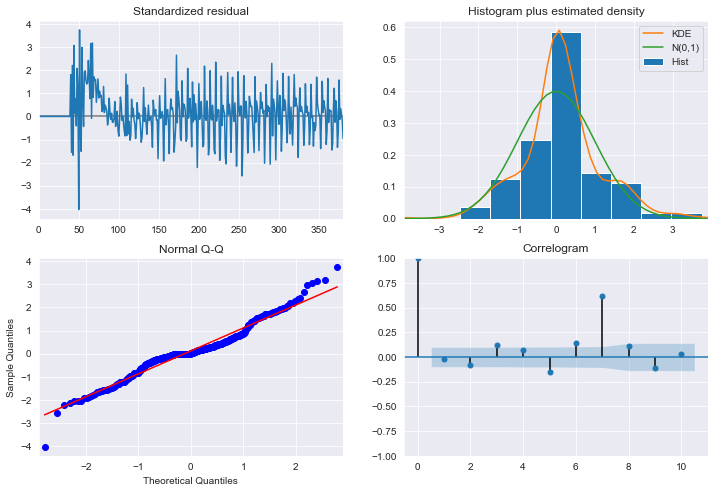

In [55]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [56]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-100], dynamic=False)
pred_conf = pred.conf_int()

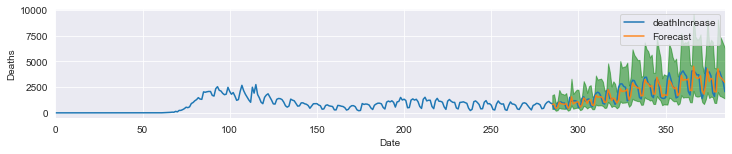

In [57]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 2

# Plot observed values
ax = deaths.plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [58]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-100:]

train_mae_death_amx = mean_absolute_error(deaths_forecasted, deaths.deathIncrease[-100:])

# Compute the mean square error
arima_train_mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
arima_train_rmse = np.sqrt(arima_train_mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(arima_train_mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(arima_train_rmse, 2)))
print('The Mean Absolute Error of our forecasts is {}'.format(round(train_mae_death_amx, 2)))

The Mean Squared Error of our forecasts is 448176.14
The Root Mean Squared Error of our forecasts is 669.46
The Mean Absolute Error of our forecasts is 497.01


In [59]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-100], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

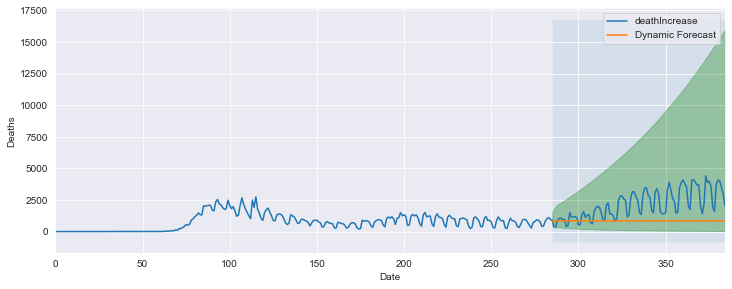

In [60]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-100], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])

plt.legend()
plt.show()

In [61]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

test_mae_death_amx = mean_absolute_error(deaths_forecasted, deaths.deathIncrease[-100:])

# Compute the mean square error
arima_test_mse = ((deaths_forecasted - deaths.deathIncrease[-100:]) ** 2).mean()
arima_test_rmse = np.sqrt(arima_test_mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(arima_test_mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(arima_test_rmse, 2)))
print('The Mean Absolute Error of our forecasts is {}'.format(round(test_mae_death_amx, 2)))

The Mean Squared Error of our forecasts is 2979911.04
The Root Mean Squared Error of our forecasts is 1726.24
The Mean Absolute Error of our forecasts is 1364.97


In [62]:
# Get forecast 30 days ahead in future
prediction = output.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

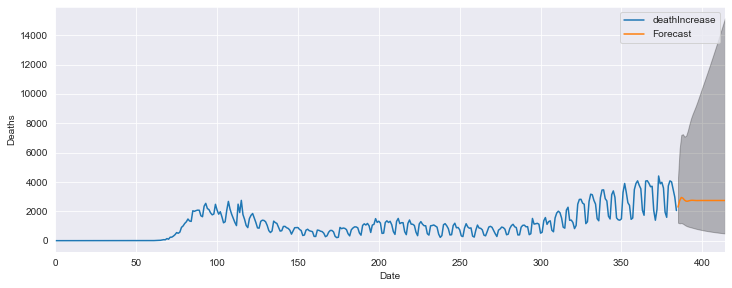

In [63]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
# plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

### SARIMAX Model

In [64]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 1)
d = range(1, 2)
q = range(1, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

p = range(0, 2)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [65]:
"""UNCOMMENT THIS CELL TO RUN GRID SEARCH"""
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(deaths,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # pickle grid parameters
# pickle_out = open("death_grid.pickle","wb")
# pickle.dump(ans_df, pickle_out)
# pickle_out.close()

'UNCOMMENT THIS CELL TO RUN GRID SEARCH'

In [66]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')

In [67]:
# Check grid search results
ans_df.loc[ans_df['aic'].idxmin()][0], ans_df.loc[ans_df['aic'].idxmin()][1]

((0, 1, 1), (0, 1, 2, 7))

In [68]:
SARIMAX_MODEL = SARIMAX(endog=np.log(deaths),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = SARIMAX_MODEL.fit()

print(output.summary().tables[0])
print(output.summary().tables[1])

                                       SARIMAX Results                                        
Dep. Variable:                          deathIncrease   No. Observations:                  385
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood                 -22.310
Date:                                Sun, 31 Jan 2021   AIC                             52.619
Time:                                        20:06:16   BIC                             68.175
Sample:                                             0   HQIC                            58.804
                                                - 385                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4377      0.033    -13.173      0.000      -0.503      -0.373
ma.

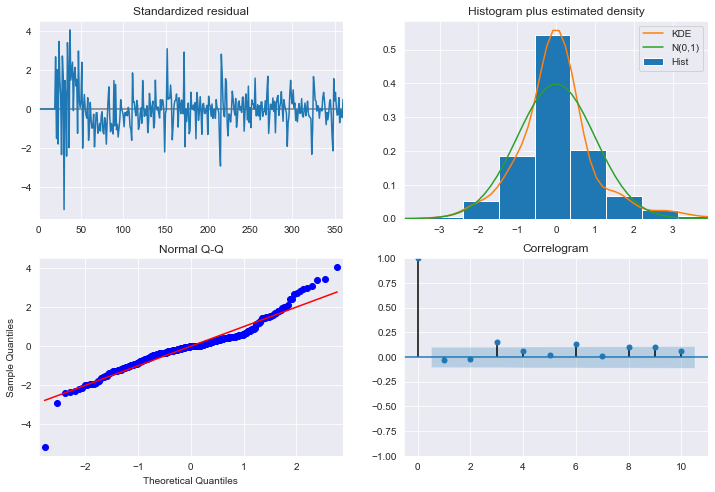

In [69]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [70]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=deaths.index[-100], dynamic=False)
pred_conf = pred.conf_int()

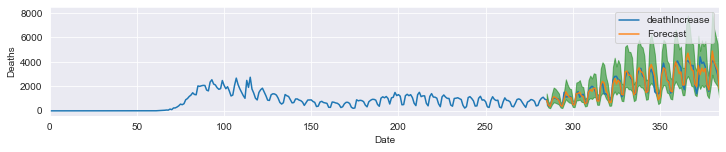

In [71]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 2

# Plot observed values
ax = deaths.plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [72]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-100:]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 150762.54
The Root Mean Squared Error of our forecasts is 388.28


In [73]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths.index[-100], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

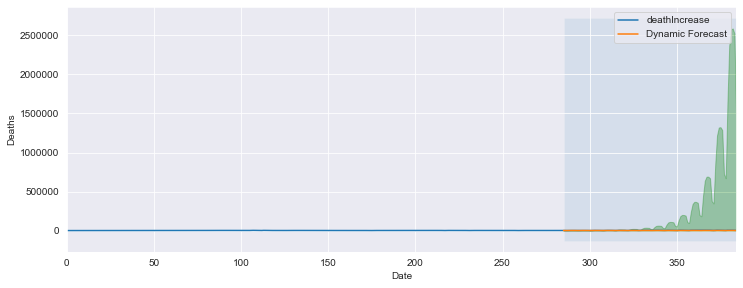

In [74]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths.index[-100], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1])

plt.legend()
plt.show()

In [75]:
# Extract the predicted and true values of our time series
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)

# Compute the mean square error
mse = ((deaths_forecasted - deaths.deathIncrease[-100:]) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 2278864.73
The Root Mean Squared Error of our forecasts is 1509.59


In [76]:
# Get forecast 30 days ahead in future
prediction = output.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

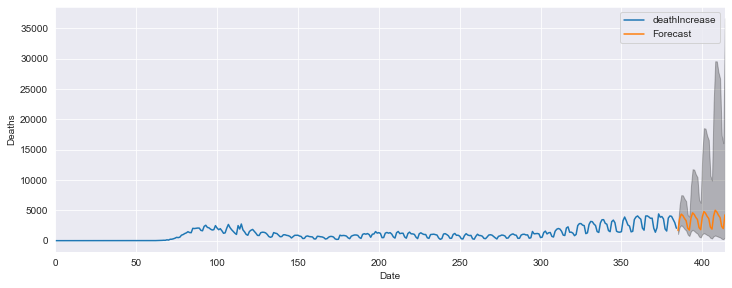

In [77]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 4.5))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
# ax.set_xlim(left=deaths.index[-90], right=deaths.index[-1]+pd.DateOffset(14))
# plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

## Facebook Prophet

In [78]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [79]:
fb_death = pd.DataFrame()
fb_death['y'] = df.deathIncrease
fb_death.reset_index(inplace=True)
fb_death = fb_death.rename(columns={'date': 'ds'})

In [80]:
death_train_fb, death_test_fb = fb_death[:-100], fb_death[-100:]

In [81]:
model_death = Prophet(interval_width=0.95)
model_death.fit(death_train_fb)

ValueError: Dataframe must have columns 'ds' and 'y' with the dates and values respectively.

In [ ]:
future_dates = model_death.make_future_dataframe(periods=100, freq='D')
forecast_death = model_death.predict(future_dates)
forecast_death.head()

In [ ]:
model_death.plot(forecast_death, uncertainty=True);

In [ ]:
model_death.plot_components(forecast_death);

In [ ]:
fb_mortality = pd.DataFrame()
fb_mortality['y'] = df.mortality
fb_mortality.reset_index(inplace=True)
fb_mortality = fb_mortality.rename(columns={'date': 'ds'})

In [ ]:
mortality_train_fb, mortality_test_fb = fb_mortality[:-100], fb_mortality[-100:]

In [ ]:
model_mortality = Prophet(interval_width=0.95)
model_mortality.fit(mortality_train_fb)

forecast_mortality = model_mortality.predict(future_dates)

## LSTM (long short-term memory) Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
df_lstm = pd.DataFrame()
df_lstm['death'] = df.deathIncrease

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [ ]:
train, test = dataset[:-100], dataset[-100:]

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original')
plt.plot(trainPredictPlot,label='trian prediction')
plt.plot(testPredictPlot,label='test prediction')
plt.legend()

## Evaluation

### metrics in ARIMA

In [85]:
print('The Training Root Mean Squared Error of our forecasts is {}'.format(round(arima_train_rmse, 2)))
print('The Testing Root Mean Squared Error of our forecasts is {}'.format(round(arima_test_rmse, 2)))
print('The Training Mean Absolute Error of our forecasts is {}'.format(round(train_mae_death_amx, 2)))
print('The Testing Mean Absolute Error of our forecasts is {}'.format(round(test_mae_death_amx, 2)))

The Training Root Mean Squared Error of our forecasts is 669.46
The Testing Root Mean Squared Error of our forecasts is 1726.24
The Training Mean Absolute Error of our forecasts is 497.01
The Testing Mean Absolute Error of our forecasts is 1364.97


### metrics in SARIMAX

In [86]:
# calculate root mean squared error
train_rmse_death_smx = mean_squared_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-100:], squared=False)
train_mae_death_smx = mean_absolute_error(np.exp(pred.predicted_mean), deaths.deathIncrease[-100:])

# calculate mean absolute error
test_rmse_death_smx = mean_squared_error(deaths_forecasted[-100:], deaths.deathIncrease[-100:], squared=False)
test_mae_death_smx = mean_absolute_error(deaths_forecasted[-100:], deaths.deathIncrease[-100:])

print('The Training Root Mean Squared Error of our forecasts is {}'.format(round(train_rmse_death_smx, 2)))
print('The Testing Root Mean Squared Error of our forecasts is {}'.format(round(test_rmse_death_smx, 2)))
print('The Training Mean Absolute Error of our forecasts is {}'.format(round(train_mae_death_smx, 2)))
print('The Testing Mean Absolute Error of our forecasts is {}'.format(round(test_mae_death_smx, 2)))

The Training Root Mean Squared Error of our forecasts is 388.28
The Testing Root Mean Squared Error of our forecasts is 1509.59
The Training Mean Absolute Error of our forecasts is 263.74
The Testing Mean Absolute Error of our forecasts is 1216.31


### metrics in Facebook Prophet

In [84]:
# calculate root mean squared error
train_rmse_death_fb = mean_squared_error(death_train_fb['y'], forecast_death['yhat'][:-100], squared=False)
test_rmse_death_fb = mean_squared_error(death_test_fb['y'], forecast_death['yhat'][-100:], squared=False)
print('Facebook Prophet deathIncrease train RMSE: {:.2f}'.format(train_rmse_death_fb))
print('Facebook Prophet deathIncrease test RMSE: {:.2f}'.format(test_rmse_death_fb))
# calculate mean absolute error
train_mae_death_fb = mean_absolute_error(death_train_fb['y'], forecast_death['yhat'][:-100])
test_mae_death_fb = mean_absolute_error(death_test_fb['y'], forecast_death['yhat'][-100:])
print('Facebook Prophet deathIncrease train MAE: {:.2f}'.format(train_mae_death_fb))
print('Facebook Prophet deathIncrease test MAE: {:.2f}'.format(test_mae_death_fb))

NameError: name 'forecast_death' is not defined

In [ ]:
# calculate root mean squared error
train_rmse_mortality_fb = mean_squared_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100], squared=False)
test_rmse_mortality_fb = mean_squared_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:], squared=False)
print('Facebook Prophet mortality train RMSE: {:.4f}'.format(train_rmse_mortality_fb))
print('Facebook Prophet mortality test RMSE: {:.4f}'.format(test_rmse_mortality_fb))
# calculate mean absolute error
train_mae_mortality_fb = mean_absolute_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100])
test_mae_mortality_fb = mean_absolute_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:])
print('Facebook Prophet mortality train MAE: {:.4f}'.format(train_mae_mortality_fb))
print('Facebook Prophet mortality test MAE: {:.4f}'.format(test_mae_mortality_fb))

### metrics in LSTM Networks

In [ ]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks deathIncrease train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks deathIncrease test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks deathIncrease train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks deathIncrease test MAE: {:.2f}'.format(testScore_mae))

## Deployment

web app can be furtherly tested and released.